# Statistical Analysis for Vietnam Coffee Data
## Phân tích thống kê dữ liệu cà phê Việt Nam

Notebook này thực hiện các kiểm định thống kê:
1. **T-Test**: So sánh giá giữa 2 tỉnh
2. **ANOVA**: So sánh giá 4 tỉnh Tây Nguyên
3. **Pearson Correlation**: Mối quan hệ Export Value ↔ World Price
4. **Linear Regression**: Dự đoán Export Value
5. **Multiple Regression**: Mô hình đa biến
6. **Weather Correlation**: Thời tiết ↔ Sản lượng

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, pearsonr, shapiro, chi2_contingency
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# Database connection
load_dotenv()

DB_HOST = os.getenv('HOST')
DB_USER = os.getenv('USER')
DB_PASSWORD = os.getenv('PASSWORD')
DB_PORT = os.getenv('PORT', '19034')
DB_NAME = os.getenv('DB', 'defaultdb')

# Create database engine
url = f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}?ssl_disabled=true"
engine = create_engine(url, pool_pre_ping=True)

# Test connection
with engine.connect() as conn:
    result = conn.execute(text("SELECT 1"))
    conn.commit()

print("✅ Database connected successfully")

✅ Database connected successfully


---
## 1. T-TEST: So sánh giá cà phê giữa 2 tỉnh
### Independent T-Test: DakLak vs DakNong

In [3]:
# Load data for T-Test
query_prices = """
SELECT date, region, price_vnd_per_kg
FROM daily_coffee_prices
WHERE date >= DATE_SUB(CURDATE(), INTERVAL 30 DAY)
ORDER BY date DESC
"""

df_prices = pd.read_sql(query_prices, engine)
print(f"📊 Loaded {len(df_prices)} price records")
print(f"Provinces: {df_prices['region'].unique()}")
print(f"Date range: {df_prices['date'].min()} to {df_prices['date'].max()}")

df_prices.head()

📊 Loaded 134 price records
Provinces: ['LamDong' 'KonTum' 'GiaLai' 'DakNong' 'DakLak']
Date range: 2025-10-13 to 2025-11-13


,date,region,price_vnd_per_kg
0,2025-11-13,LamDong,130684
1,2025-11-13,KonTum,130398
2,2025-11-13,GiaLai,130407
3,2025-11-13,DakNong,132671
4,2025-11-13,DakLak,131264


In [4]:
# Perform T-Test: DakLak vs DakNong
daklak_prices = df_prices[df_prices['region'] == 'DakLak']['price_vnd_per_kg']
daknong_prices = df_prices[df_prices['region'] == 'DakNong']['price_vnd_per_kg']

# Independent T-Test
t_statistic, p_value = stats.ttest_ind(daklak_prices, daknong_prices)

# Calculate statistics
daklak_mean = daklak_prices.mean()
daknong_mean = daknong_prices.mean()
daklak_std = daklak_prices.std()
daknong_std = daknong_prices.std()
mean_diff = daklak_mean - daknong_mean

# Display results
print("="*80)
print("T-TEST RESULTS: DakLak vs DakNong")
print("="*80)
print(f"\nDakLak:")
print(f"  Mean: {daklak_mean:,.0f} VND/kg")
print(f"  Std:  {daklak_std:,.0f} VND/kg")
print(f"  N:    {len(daklak_prices)}")

print(f"\nDakNong:")
print(f"  Mean: {daknong_mean:,.0f} VND/kg")
print(f"  Std:  {daknong_std:,.0f} VND/kg")
print(f"  N:    {len(daknong_prices)}")

print(f"\n{'='*80}")
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value:     {p_value:.4f}")
print(f"Mean Diff:   {mean_diff:,.0f} VND/kg")
print(f"\n{'='*80}")

if p_value < 0.05:
    print(f"✅ SIGNIFICANT: DakLak {'cao hơn' if mean_diff > 0 else 'thấp hơn'} DakNong {abs(mean_diff):,.0f} VND/kg (p={p_value:.4f})")
else:
    print(f"❌ NOT SIGNIFICANT: Không có sự khác biệt có ý nghĩa thống kê (p={p_value:.4f})")

T-TEST RESULTS: DakLak vs DakNong

DakLak:
  Mean: 131,108 VND/kg
  Std:  1,491 VND/kg
  N:    32

DakNong:
  Mean: 131,507 VND/kg
  Std:  1,594 VND/kg
  N:    32

T-statistic: -1.0342
P-value:     0.3051
Mean Diff:   -399 VND/kg

❌ NOT SIGNIFICANT: Không có sự khác biệt có ý nghĩa thống kê (p=0.3051)


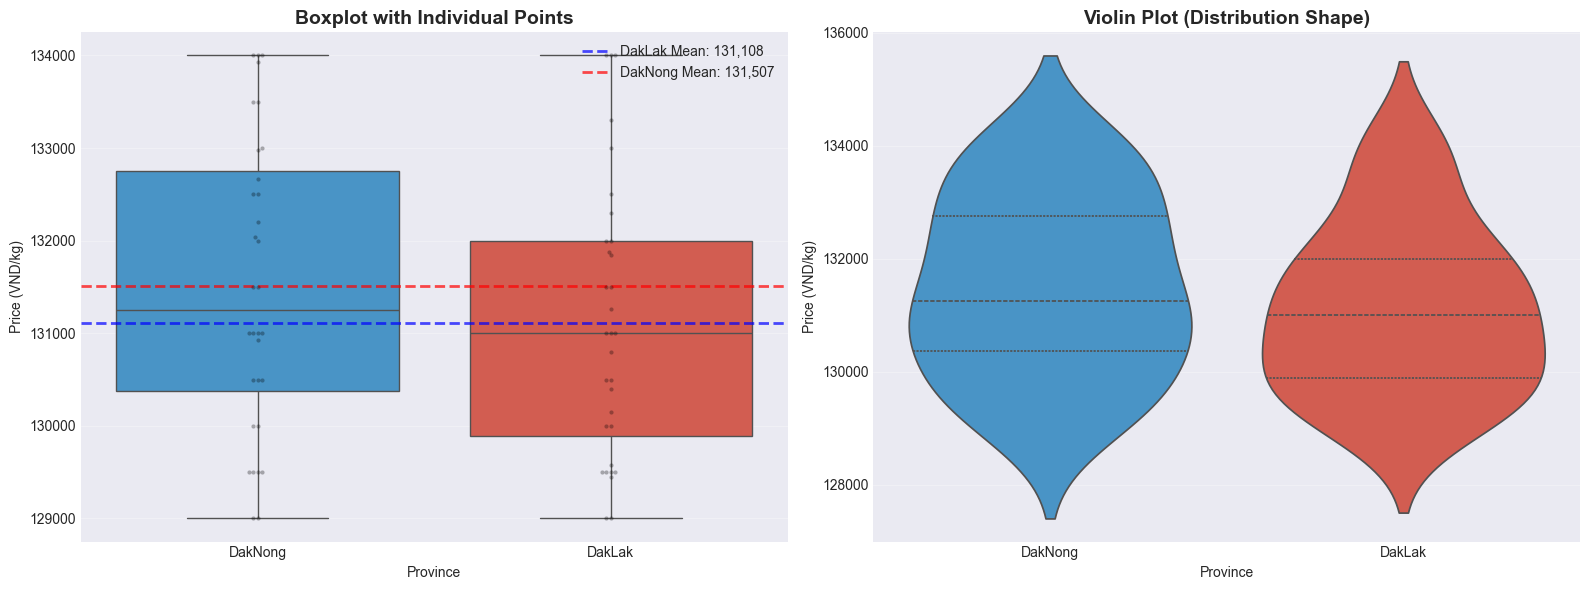

📊 Chart 1: Boxplot & Violin Plot


In [5]:
# T-TEST VISUALIZATION 1: Boxplot & Violin Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_compare = df_prices[df_prices['region'].isin(['DakLak', 'DakNong'])]

# Boxplot with swarm
sns.boxplot(data=df_compare, x='region', y='price_vnd_per_kg', ax=axes[0], palette=['#3498db', '#e74c3c'])
sns.swarmplot(data=df_compare, x='region', y='price_vnd_per_kg', ax=axes[0], 
              color='black', alpha=0.3, size=3)
axes[0].set_title('Boxplot with Individual Points', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (VND/kg)')
axes[0].set_xlabel('Province')
axes[0].axhline(daklak_mean, color='blue', linestyle='--', alpha=0.7, linewidth=2, label=f'DakLak Mean: {daklak_mean:,.0f}')
axes[0].axhline(daknong_mean, color='red', linestyle='--', alpha=0.7, linewidth=2, label=f'DakNong Mean: {daknong_mean:,.0f}')
axes[0].legend(loc='upper right')
axes[0].grid(axis='y', alpha=0.3)

# Violin plot
sns.violinplot(data=df_compare, x='region', y='price_vnd_per_kg', ax=axes[1], 
               palette=['#3498db', '#e74c3c'], inner='quartile')
axes[1].set_title('Violin Plot (Distribution Shape)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Price (VND/kg)')
axes[1].set_xlabel('Province')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Chart 1: Boxplot & Violin Plot")

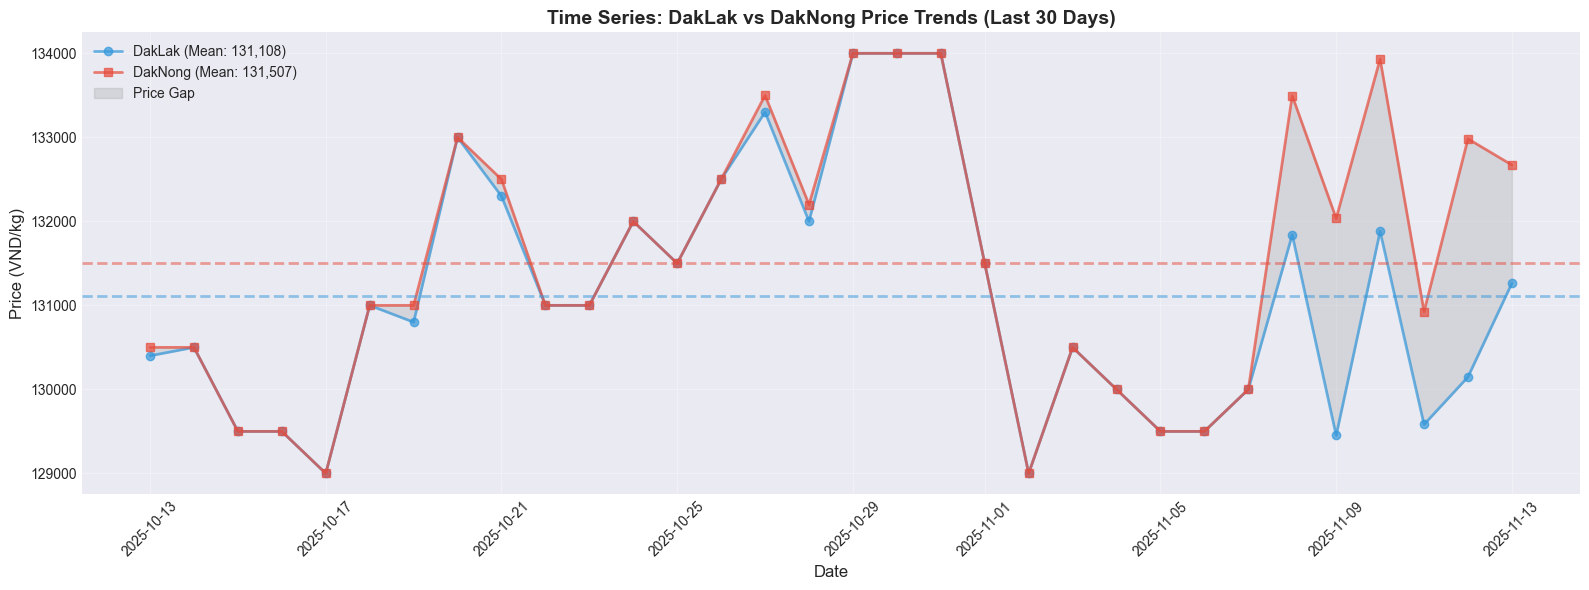

📊 Chart 2: Time Series Comparison


In [6]:
# T-TEST VISUALIZATION 2: Time Series Comparison
fig, ax = plt.subplots(figsize=(16, 6))

# Plot price trends for both provinces
daklak_data = df_prices[df_prices['region'] == 'DakLak'].sort_values('date')
daknong_data = df_prices[df_prices['region'] == 'DakNong'].sort_values('date')

ax.plot(daklak_data['date'], daklak_data['price_vnd_per_kg'], 
        marker='o', linewidth=2, markersize=6, alpha=0.7, 
        label=f'DakLak (Mean: {daklak_mean:,.0f})', color='#3498db')

ax.plot(daknong_data['date'], daknong_data['price_vnd_per_kg'], 
        marker='s', linewidth=2, markersize=6, alpha=0.7,
        label=f'DakNong (Mean: {daknong_mean:,.0f})', color='#e74c3c')

# Add mean lines
ax.axhline(daklak_mean, color='#3498db', linestyle='--', alpha=0.5, linewidth=2)
ax.axhline(daknong_mean, color='#e74c3c', linestyle='--', alpha=0.5, linewidth=2)

# Fill area between the lines
ax.fill_between(daklak_data['date'], 
                daklak_data['price_vnd_per_kg'].values, 
                daknong_data['price_vnd_per_kg'].values,
                alpha=0.2, color='gray', label='Price Gap')

ax.set_title('Time Series: DakLak vs DakNong Price Trends (Last 30 Days)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (VND/kg)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("📊 Chart 2: Time Series Comparison")

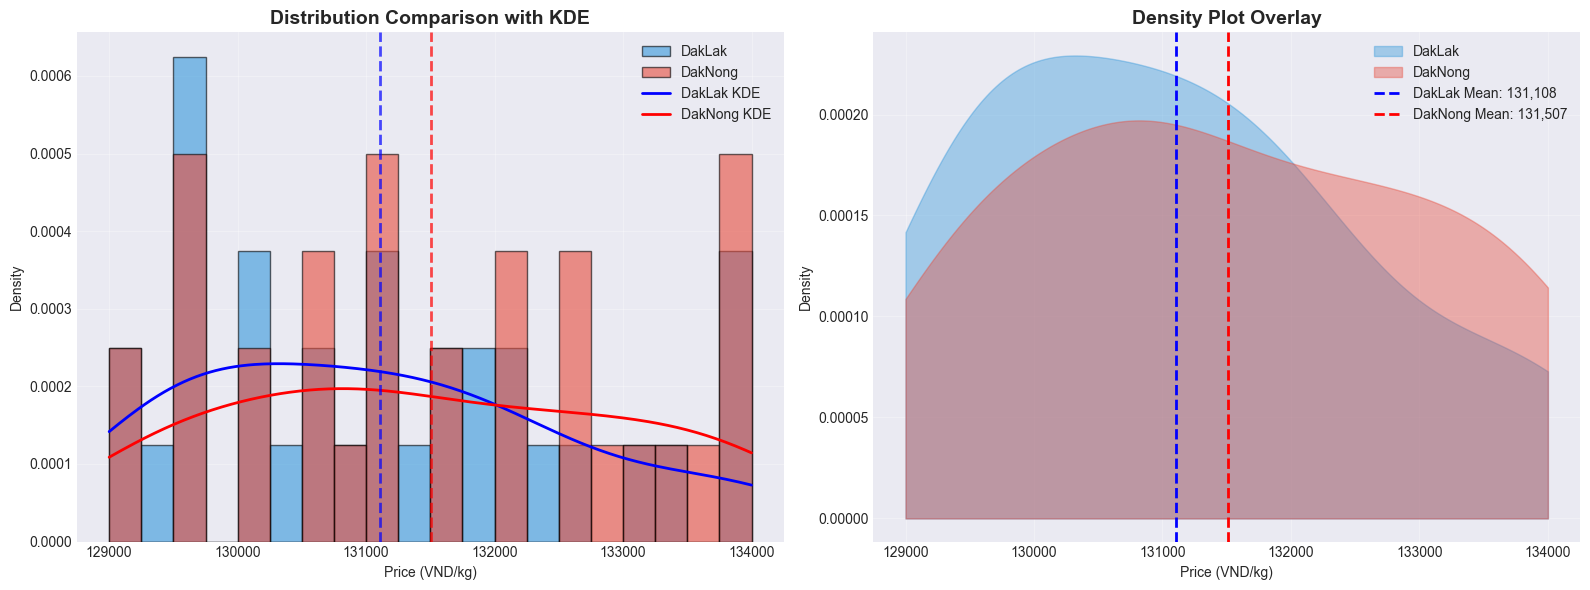

📊 Chart 3: Histogram & Density Plot


In [7]:
# T-TEST VISUALIZATION 3: Histogram & Density Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram with KDE
axes[0].hist(daklak_prices, bins=20, alpha=0.6, color='#3498db', 
             edgecolor='black', label='DakLak', density=True)
axes[0].hist(daknong_prices, bins=20, alpha=0.6, color='#e74c3c', 
             edgecolor='black', label='DakNong', density=True)

# Add KDE
from scipy.stats import gaussian_kde
kde_daklak = gaussian_kde(daklak_prices)
kde_daknong = gaussian_kde(daknong_prices)

x_range = np.linspace(min(daklak_prices.min(), daknong_prices.min()),
                      max(daklak_prices.max(), daknong_prices.max()), 200)
axes[0].plot(x_range, kde_daklak(x_range), 'b-', linewidth=2, label='DakLak KDE')
axes[0].plot(x_range, kde_daknong(x_range), 'r-', linewidth=2, label='DakNong KDE')

axes[0].axvline(daklak_mean, color='blue', linestyle='--', linewidth=2, alpha=0.7)
axes[0].axvline(daknong_mean, color='red', linestyle='--', linewidth=2, alpha=0.7)

axes[0].set_title('Distribution Comparison with KDE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Price (VND/kg)')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Overlapping Density Plot
axes[1].fill_between(x_range, kde_daklak(x_range), alpha=0.4, color='#3498db', label='DakLak')
axes[1].fill_between(x_range, kde_daknong(x_range), alpha=0.4, color='#e74c3c', label='DakNong')
axes[1].axvline(daklak_mean, color='blue', linestyle='--', linewidth=2, label=f'DakLak Mean: {daklak_mean:,.0f}')
axes[1].axvline(daknong_mean, color='red', linestyle='--', linewidth=2, label=f'DakNong Mean: {daknong_mean:,.0f}')

axes[1].set_title('Density Plot Overlay', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Price (VND/kg)')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Chart 3: Histogram & Density Plot")

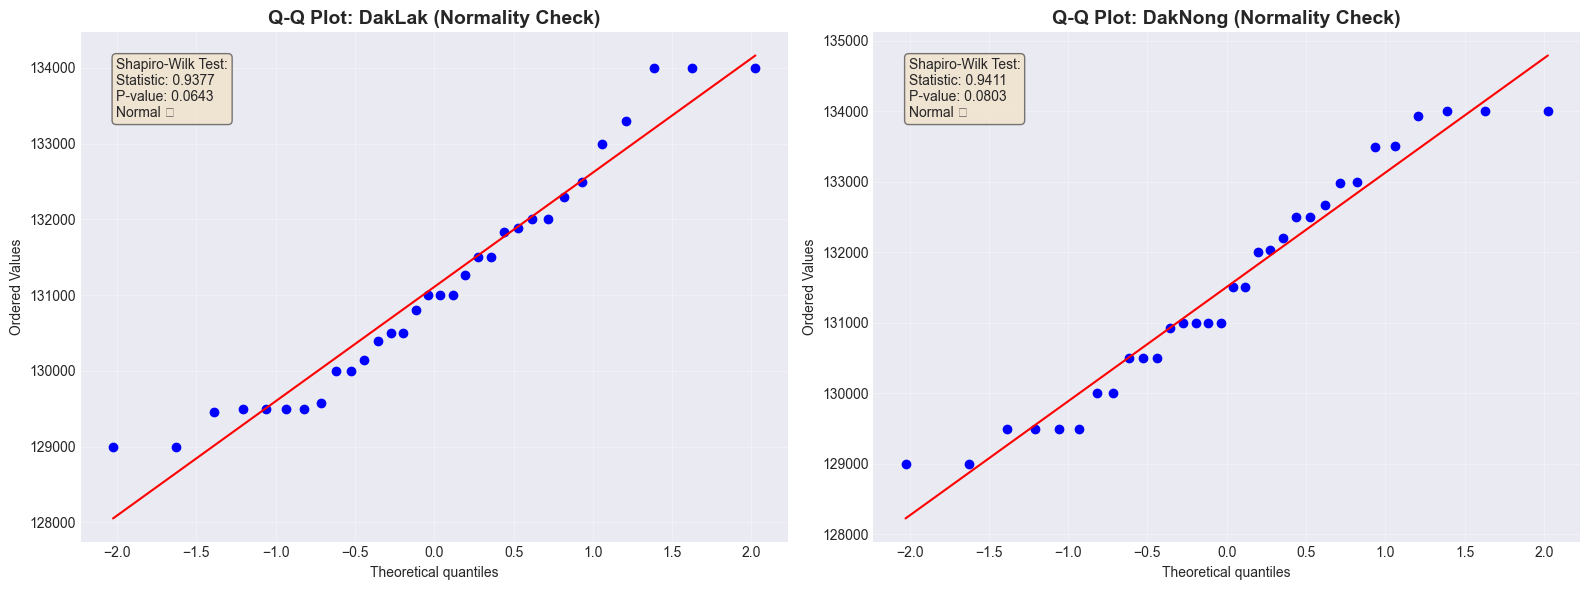

📊 Chart 4: Q-Q Plot (Normality Test)

🔍 Normality Test Results:
  DakLak:  Shapiro-Wilk p=0.0643 (Normal ✅)
  DakNong: Shapiro-Wilk p=0.0803 (Normal ✅)


In [8]:
# T-TEST VISUALIZATION 4: Q-Q Plot (Normality Check)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Q-Q plot for DakLak
stats.probplot(daklak_prices, dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot: DakLak (Normality Check)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Shapiro-Wilk test for DakLak
shapiro_stat_dl, shapiro_p_dl = shapiro(daklak_prices)
axes[0].text(0.05, 0.95, f'Shapiro-Wilk Test:\nStatistic: {shapiro_stat_dl:.4f}\nP-value: {shapiro_p_dl:.4f}\n{"Normal ✅" if shapiro_p_dl > 0.05 else "Not Normal ❌"}',
             transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Q-Q plot for DakNong
stats.probplot(daknong_prices, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: DakNong (Normality Check)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# Shapiro-Wilk test for DakNong
shapiro_stat_dn, shapiro_p_dn = shapiro(daknong_prices)
axes[1].text(0.05, 0.95, f'Shapiro-Wilk Test:\nStatistic: {shapiro_stat_dn:.4f}\nP-value: {shapiro_p_dn:.4f}\n{"Normal ✅" if shapiro_p_dn > 0.05 else "Not Normal ❌"}',
             transform=axes[1].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("📊 Chart 4: Q-Q Plot (Normality Test)")
print(f"\n🔍 Normality Test Results:")
print(f"  DakLak:  Shapiro-Wilk p={shapiro_p_dl:.4f} {'(Normal ✅)' if shapiro_p_dl > 0.05 else '(Not Normal ❌)'}")
print(f"  DakNong: Shapiro-Wilk p={shapiro_p_dn:.4f} {'(Normal ✅)' if shapiro_p_dn > 0.05 else '(Not Normal ❌)'}")

---
## 2. ONE-WAY ANOVA: So sánh giá 4 tỉnh Tây Nguyên

In [9]:
# Prepare data for ANOVA (4 provinces)
daklak = df_prices[df_prices['region'] == 'DakLak']['price_vnd_per_kg']
daknong = df_prices[df_prices['region'] == 'DakNong']['price_vnd_per_kg']
gialai = df_prices[df_prices['region'] == 'GiaLai']['price_vnd_per_kg']
lamdong = df_prices[df_prices['region'] == 'LamDong']['price_vnd_per_kg']

# One-Way ANOVA
f_statistic, p_value_anova = f_oneway(daklak, daknong, gialai, lamdong)

# Calculate means
means = {
    'DakLak': daklak.mean(),
    'DakNong': daknong.mean(),
    'GiaLai': gialai.mean(),
    'LamDong': lamdong.mean()
}

print("="*80)
print("ONE-WAY ANOVA RESULTS: 4 Tỉnh Tây Nguyên")
print("="*80)
print("\nMean Prices:")
for province, mean in means.items():
    print(f"  {province:10} {mean:,.0f} VND/kg")

print(f"\n{'='*80}")
print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value:     {p_value_anova:.4f}")
print(f"{'='*80}")

if p_value_anova < 0.05:
    print(f"\n✅ SIGNIFICANT: Có ít nhất 1 tỉnh có giá khác biệt có ý nghĩa (p={p_value_anova:.4f})")
else:
    print(f"\n❌ NOT SIGNIFICANT: Không có sự khác biệt giữa các tỉnh (p={p_value_anova:.4f})")

ONE-WAY ANOVA RESULTS: 4 Tỉnh Tây Nguyên

Mean Prices:
  DakLak     131,108 VND/kg
  DakNong    131,507 VND/kg
  GiaLai     131,112 VND/kg
  LamDong    130,048 VND/kg

F-statistic: 4.9645
P-value:     0.0027

✅ SIGNIFICANT: Có ít nhất 1 tỉnh có giá khác biệt có ý nghĩa (p=0.0027)


In [10]:
# Post-hoc Tukey HSD test (if ANOVA is significant)
if p_value_anova < 0.05:
    print("\n" + "="*80)
    print("POST-HOC TUKEY HSD TEST")
    print("="*80)
    
    # Prepare data for Tukey
    all_prices = pd.concat([
        pd.DataFrame({'price': daklak, 'province': 'DakLak'}),
        pd.DataFrame({'price': daknong, 'province': 'DakNong'}),
        pd.DataFrame({'price': gialai, 'province': 'GiaLai'}),
        pd.DataFrame({'price': lamdong, 'province': 'LamDong'})
    ])
    
    tukey = pairwise_tukeyhsd(all_prices['price'], all_prices['province'], alpha=0.05)
    print(tukey)
    
    # Convert to DataFrame for easier viewing
    tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    print("\nSignificant pairs (reject=True):")
    print(tukey_df[tukey_df['reject'] == True])


POST-HOC TUKEY HSD TEST
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1  group2  meandiff  p-adj    lower      upper   reject
-------------------------------------------------------------
 DakLak DakNong    399.125 0.7468  -635.2338 1433.4838  False
 DakLak  GiaLai     4.0625    1.0 -1030.2963 1038.4213  False
 DakLak LamDong -1059.8438 0.0424 -2094.2026  -25.4849   True
DakNong  GiaLai  -395.0625 0.7527 -1429.4213  639.2963  False
DakNong LamDong -1458.9688  0.002 -2493.3276 -424.6099   True
 GiaLai LamDong -1063.9062 0.0413 -2098.2651  -29.5474   True
-------------------------------------------------------------

Significant pairs (reject=True):
    group1   group2   meandiff   p-adj      lower     upper  reject
2   DakLak  LamDong -1059.8438  0.0424 -2094.2026  -25.4849    True
4  DakNong  LamDong -1458.9688  0.0020 -2493.3276 -424.6099    True
5   GiaLai  LamDong -1063.9062  0.0413 -2098.2651  -29.5474    True
     Multiple Comparison of Means - Tukey HSD, FW

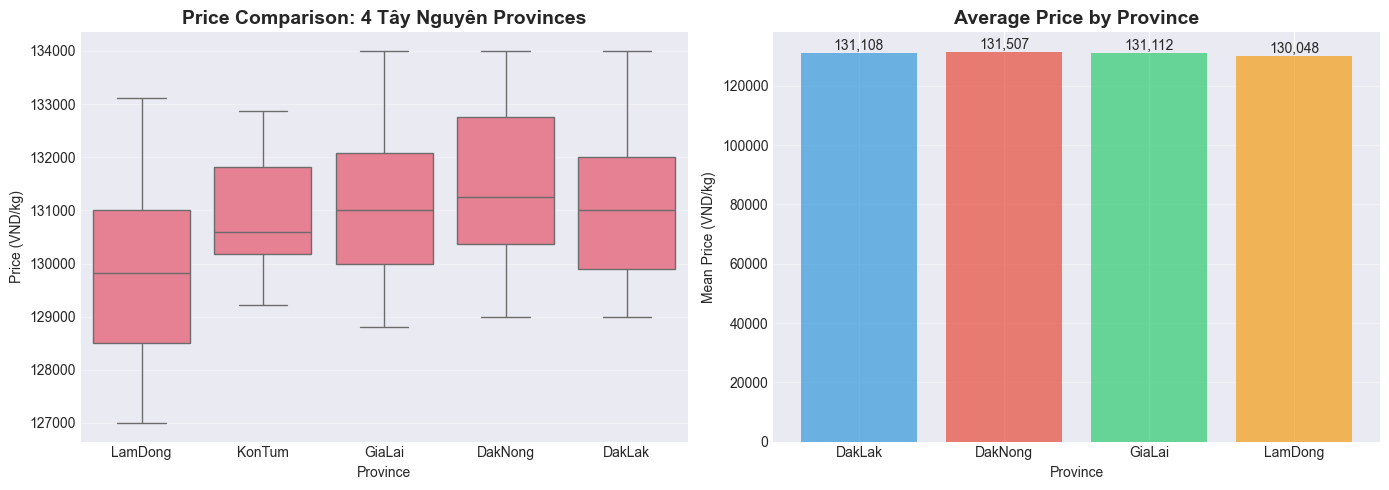


📊 Visualization: ANOVA comparison of 4 provinces


In [11]:
# Visualize ANOVA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot for all 4 provinces
sns.boxplot(data=df_prices, x='region', y='price_vnd_per_kg', ax=axes[0])
axes[0].set_title('Price Comparison: 4 Tây Nguyên Provinces', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (VND/kg)')
axes[0].set_xlabel('Province')
axes[0].grid(axis='y', alpha=0.3)

# Bar chart of means
provinces = list(means.keys())
mean_values = list(means.values())
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
bars = axes[1].bar(provinces, mean_values, color=colors, alpha=0.7)
axes[1].set_title('Average Price by Province', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Mean Price (VND/kg)')
axes[1].set_xlabel('Province')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n📊 Visualization: ANOVA comparison of 4 provinces")

---
## 3. PEARSON CORRELATION: Export Value ↔ World Price

In [12]:
# Load export performance data
query_export = """
SELECT year,
       export_value_million_usd,
       price_world_usd_per_ton,
       price_vn_usd_per_ton,
       production_tons,
       area_thousand_ha,
       export_tons
FROM export_performance
WHERE year >= 2007
  AND export_value_million_usd IS NOT NULL
  AND price_world_usd_per_ton IS NOT NULL
ORDER BY year
"""

df_export = pd.read_sql(query_export, engine)
print(f"📊 Loaded {len(df_export)} years of export data (2007-2024)")
df_export.head(10)

📊 Loaded 18 years of export data (2007-2024)


,year,export_value_million_usd,price_world_usd_per_ton,price_vn_usd_per_ton,production_tons,area_thousand_ha,export_tons
0,2007,1911.00,1910.01,1554.92,1251000.0,509.3,1229000.0
1,2008,2111.00,2319.18,1991.51,1055811.0,530.9,1060000.0
2,2009,1730.60,1643.41,1462.24,1057540.0,538.5,1183523.0
3,2010,1851.36,1735.72,1520.16,1105700.0,554.8,1217868.0
4,2011,2752.42,2408.29,2189.25,1276506.0,586.2,1257246.0
5,2012,3672.81,2267.30,2120.37,1260463.0,623.0,1732156.0
6,2013,2717.51,2074.93,2090.16,1326688.0,637.0,1300146.0
7,2014,3556.89,2213.86,2103.97,1406469.0,641.2,1690564.0
8,2015,2671.33,1940.87,1991.79,1452999.0,643.3,1341169.0
9,2016,3334.25,1953.66,1872.83,1460800.0,650.6,1780328.0


In [13]:
# Pearson Correlation: Export Value ↔ World Price
r_coef, p_value_corr = pearsonr(df_export['export_value_million_usd'], 
                                  df_export['price_world_usd_per_ton'])

print("="*80)
print("PEARSON CORRELATION: Export Value ↔ World Price")
print("="*80)
print(f"\nCorrelation coefficient (r): {r_coef:.4f}")
print(f"P-value:                     {p_value_corr:.4f}")
print(f"R² (variance explained):     {r_coef**2:.4f} ({r_coef**2*100:.2f}%)")
print(f"\n{'='*80}")

# Interpret correlation strength
if abs(r_coef) > 0.7:
    strength = "STRONG"
elif abs(r_coef) > 0.4:
    strength = "MODERATE"
else:
    strength = "WEAK"

direction = "positive" if r_coef > 0 else "negative"

if p_value_corr < 0.05:
    print(f"✅ SIGNIFICANT: {strength} {direction} correlation (p={p_value_corr:.4f})")
else:
    print(f"❌ NOT SIGNIFICANT: Correlation not statistically significant (p={p_value_corr:.4f})")

PEARSON CORRELATION: Export Value ↔ World Price

Correlation coefficient (r): 0.7695
P-value:                     0.0002
R² (variance explained):     0.5921 (59.21%)

✅ SIGNIFICANT: STRONG positive correlation (p=0.0002)


In [14]:
# Correlation Matrix (all numerical variables)
numerical_cols = ['export_value_million_usd', 'price_world_usd_per_ton', 
                  'price_vn_usd_per_ton', 'production_tons', 
                  'area_thousand_ha', 'export_tons']

# Remove columns with too many NaN
available_cols = [col for col in numerical_cols if col in df_export.columns and df_export[col].notna().sum() > 10]
corr_matrix = df_export[available_cols].corr()

print("\n" + "="*80)
print("CORRELATION MATRIX")
print("="*80)
print(corr_matrix.round(3))

# Find strongest correlation
corr_flat = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
strongest_corr = corr_flat.stack().idxmax()
strongest_value = corr_flat.stack().max()

print(f"\n🔥 Strongest correlation: {strongest_corr[0]} ↔ {strongest_corr[1]} (r={strongest_value:.3f})")


CORRELATION MATRIX
                          export_value_million_usd  price_world_usd_per_ton  \
export_value_million_usd                     1.000                    0.770   
price_world_usd_per_ton                      0.770                    1.000   
price_vn_usd_per_ton                         0.864                    0.970   
production_tons                              0.725                    0.124   
area_thousand_ha                             0.792                    0.341   
export_tons                                  0.543                   -0.094   

                          price_vn_usd_per_ton  production_tons  \
export_value_million_usd                 0.864            0.725   
price_world_usd_per_ton                  0.970            0.124   
price_vn_usd_per_ton                     1.000            0.499   
production_tons                          0.499            1.000   
area_thousand_ha                         0.542            0.918   
export_tons             

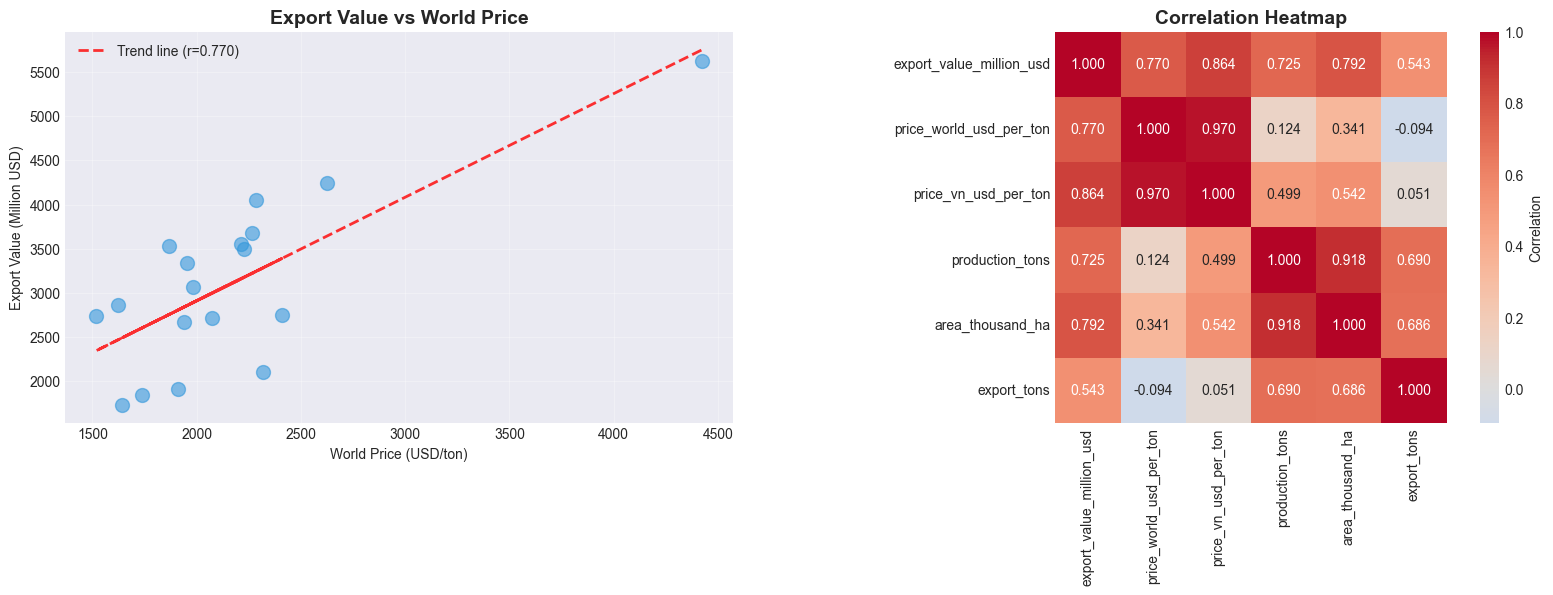


📊 Visualization: Correlation analysis


In [15]:
# Visualize Correlation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot: Export Value vs World Price
axes[0].scatter(df_export['price_world_usd_per_ton'], 
                df_export['export_value_million_usd'],
                s=100, alpha=0.6, color='#3498db')

# Add trend line
z = np.polyfit(df_export['price_world_usd_per_ton'], 
               df_export['export_value_million_usd'], 1)
p = np.poly1d(z)
axes[0].plot(df_export['price_world_usd_per_ton'], 
             p(df_export['price_world_usd_per_ton']), 
             "r--", alpha=0.8, linewidth=2,
             label=f'Trend line (r={r_coef:.3f})')

axes[0].set_title('Export Value vs World Price', fontsize=14, fontweight='bold')
axes[0].set_xlabel('World Price (USD/ton)')
axes[0].set_ylabel('Export Value (Million USD)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Correlation Heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, ax=axes[1],
            cbar_kws={'label': 'Correlation'})
axes[1].set_title('Correlation Heatmap', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Visualization: Correlation analysis")

---
## 4. SIMPLE LINEAR REGRESSION: Export Value ~ World Price

In [16]:
# Simple Linear Regression
X = df_export[['price_world_usd_per_ton']].values
y = df_export['export_value_million_usd'].values

# Add constant (intercept)
X_with_const = sm.add_constant(X)

# Fit model
model_simple = sm.OLS(y, X_with_const).fit()

print("="*80)
print("SIMPLE LINEAR REGRESSION")
print("Model: Export_Value = β0 + β1 * World_Price")
print("="*80)
print(model_simple.summary())

# Extract key metrics
print("\n" + "="*80)
print("KEY METRICS")
print("="*80)
print(f"R-squared:           {model_simple.rsquared:.4f} ({model_simple.rsquared*100:.2f}% variance explained)")
print(f"Adjusted R-squared:  {model_simple.rsquared_adj:.4f}")
print(f"F-statistic:         {model_simple.fvalue:.4f}")
print(f"P-value (F-test):    {model_simple.f_pvalue:.6f}")
print(f"\nIntercept (β0):      {model_simple.params[0]:,.2f}")
print(f"Coefficient (β1):    {model_simple.params[1]:.4f}")
print(f"\nInterpretation: Mỗi $1 tăng giá thế giới → Export value tăng ${model_simple.params[1]:.2f} triệu USD")

SIMPLE LINEAR REGRESSION
Model: Export_Value = β0 + β1 * World_Price
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     23.23
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           0.000189
Time:                        05:46:54   Log-Likelihood:                -140.74
No. Observations:                  18   AIC:                             285.5
Df Residuals:                      16   BIC:                             287.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

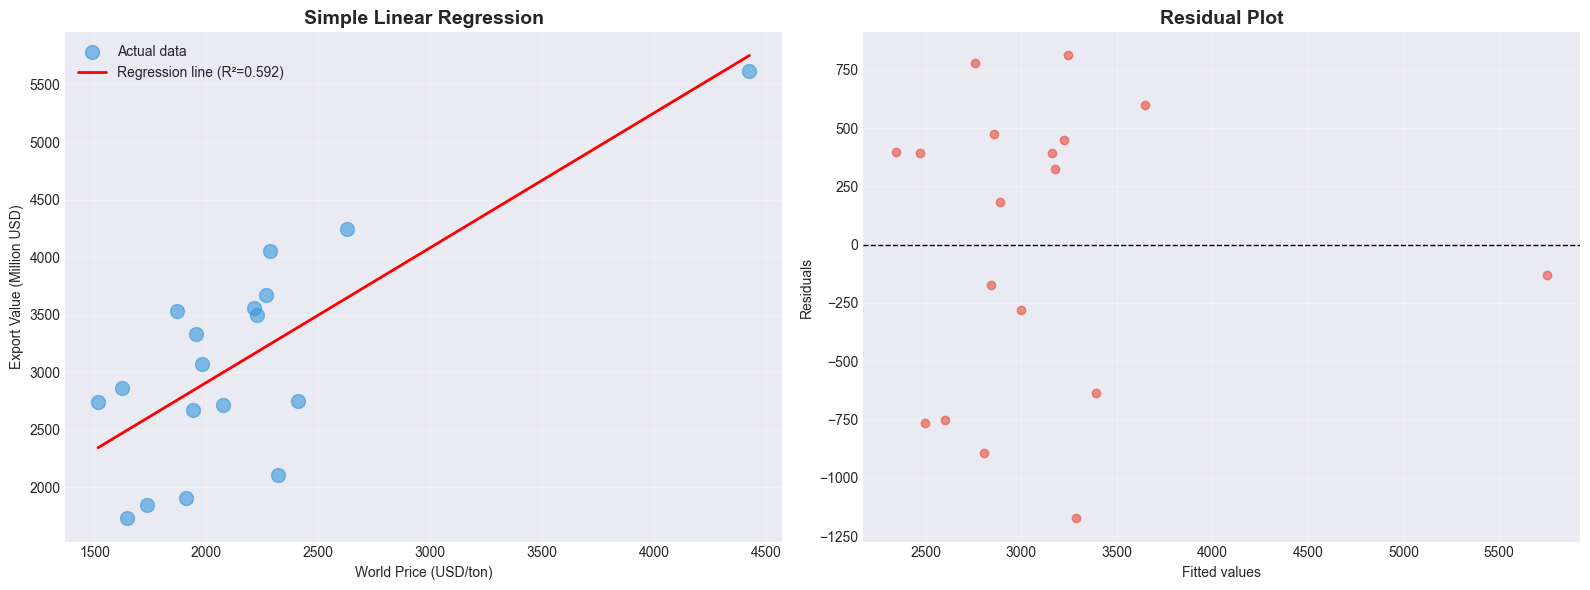


📊 Visualization: Simple Linear Regression


In [17]:
# Visualize Regression
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Regression plot
axes[0].scatter(df_export['price_world_usd_per_ton'], 
                df_export['export_value_million_usd'],
                s=100, alpha=0.6, color='#3498db', label='Actual data')

# Prediction line
x_pred = np.linspace(df_export['price_world_usd_per_ton'].min(), 
                     df_export['price_world_usd_per_ton'].max(), 100)
y_pred = model_simple.params[0] + model_simple.params[1] * x_pred
axes[0].plot(x_pred, y_pred, 'r-', linewidth=2, 
             label=f'Regression line (R²={model_simple.rsquared:.3f})')

axes[0].set_title('Simple Linear Regression', fontsize=14, fontweight='bold')
axes[0].set_xlabel('World Price (USD/ton)')
axes[0].set_ylabel('Export Value (Million USD)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residual plot
residuals = model_simple.resid
axes[1].scatter(model_simple.fittedvalues, residuals, alpha=0.6, color='#e74c3c')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fitted values')
axes[1].set_ylabel('Residuals')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Visualization: Simple Linear Regression")

---
## 5. MULTIPLE LINEAR REGRESSION: Export Value ~ Multiple Variables

In [18]:
# Multiple Linear Regression
# Filter data with complete information
df_complete = df_export[['export_value_million_usd', 'price_world_usd_per_ton', 
                         'production_tons', 'area_thousand_ha']].dropna()

print(f"Using {len(df_complete)} complete records for multiple regression")

# Prepare variables
X_multi = df_complete[['price_world_usd_per_ton', 'production_tons', 'area_thousand_ha']]
y_multi = df_complete['export_value_million_usd']

# Add constant
X_multi_const = sm.add_constant(X_multi)

# Fit model
model_multi = sm.OLS(y_multi, X_multi_const).fit()

print("\n" + "="*80)
print("MULTIPLE LINEAR REGRESSION")
print("Model: Export_Value = β0 + β1*World_Price + β2*Production + β3*Area")
print("="*80)
print(model_multi.summary())

Using 17 complete records for multiple regression

MULTIPLE LINEAR REGRESSION
Model: Export_Value = β0 + β1*World_Price + β2*Production + β3*Area
                               OLS Regression Results                               
Dep. Variable:     export_value_million_usd   R-squared:                       0.869
Model:                                  OLS   Adj. R-squared:                  0.839
Method:                       Least Squares   F-statistic:                     28.77
Date:                      Thu, 13 Nov 2025   Prob (F-statistic):           5.21e-06
Time:                              05:46:55   Log-Likelihood:                -119.14
No. Observations:                        17   AIC:                             246.3
Df Residuals:                            13   BIC:                             249.6
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
    

In [19]:
# Check for Multicollinearity (VIF)
print("\n" + "="*80)
print("MULTICOLLINEARITY CHECK (VIF)")
print("="*80)
print("VIF > 10 indicates high multicollinearity\n")

vif_data = pd.DataFrame()
vif_data["Variable"] = X_multi.columns
vif_data["VIF"] = [variance_inflation_factor(X_multi.values, i) for i in range(X_multi.shape[1])]
print(vif_data)

# Interpretation
print("\n" + "="*80)
print("KEY METRICS")
print("="*80)
print(f"R-squared:           {model_multi.rsquared:.4f} ({model_multi.rsquared*100:.2f}% variance explained)")
print(f"Adjusted R-squared:  {model_multi.rsquared_adj:.4f}")
print(f"F-statistic:         {model_multi.fvalue:.4f}")
print(f"P-value (F-test):    {model_multi.f_pvalue:.6f}")

print("\nCoefficients:")
for i, var in enumerate(['Intercept'] + list(X_multi.columns)):
    coef = model_multi.params[i]
    pval = model_multi.pvalues[i]
    sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
    print(f"  {var:25} β={coef:10.4f}  p={pval:.4f} {sig}")


MULTICOLLINEARITY CHECK (VIF)
VIF > 10 indicates high multicollinearity

                  Variable         VIF
0  price_world_usd_per_ton   39.556379
1          production_tons   98.327315
2         area_thousand_ha  175.274593

KEY METRICS
R-squared:           0.8691 (86.91% variance explained)
Adjusted R-squared:  0.8389
F-statistic:         28.7656
P-value (F-test):    0.000005

Coefficients:
  Intercept                 β=-5288.8498  p=0.0004 ***
  price_world_usd_per_ton   β=    1.1963  p=0.0004 ***
  production_tons           β=   -0.0004  p=0.5681 
  area_thousand_ha          β=   10.0605  p=0.0039 **


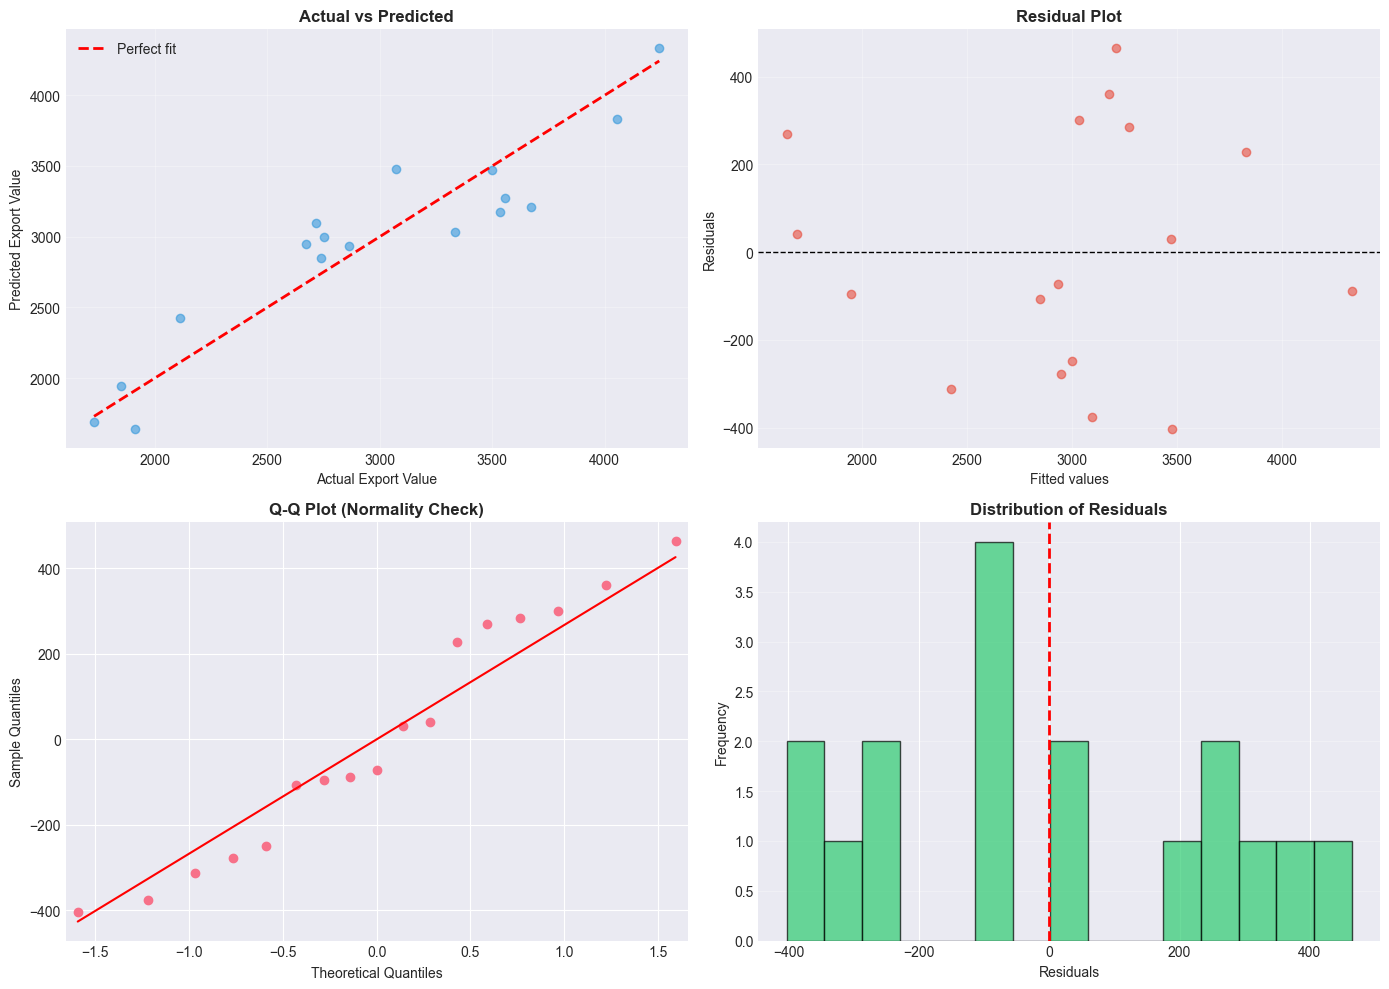


📊 Visualization: Multiple Linear Regression diagnostics


In [20]:
# Visualize Multiple Regression
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Actual vs Predicted
axes[0, 0].scatter(y_multi, model_multi.fittedvalues, alpha=0.6, color='#3498db')
axes[0, 0].plot([y_multi.min(), y_multi.max()], [y_multi.min(), y_multi.max()], 
                'r--', linewidth=2, label='Perfect fit')
axes[0, 0].set_title('Actual vs Predicted', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Actual Export Value')
axes[0, 0].set_ylabel('Predicted Export Value')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Residual plot
residuals_multi = model_multi.resid
axes[0, 1].scatter(model_multi.fittedvalues, residuals_multi, alpha=0.6, color='#e74c3c')
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Fitted values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].grid(alpha=0.3)

# Q-Q plot for normality
sm.qqplot(residuals_multi, line='s', ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')

# Histogram of residuals
axes[1, 1].hist(residuals_multi, bins=15, alpha=0.7, color='#2ecc71', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Visualization: Multiple Linear Regression diagnostics")

---
## 6. WEATHER CORRELATION: Temperature & Rainfall ↔ Production

In [21]:
# Load weather and production data
query_weather_prod = """
SELECT 
    w.province, 
    w.year,
    AVG(w.temperature_mean) as avg_temp,
    SUM(w.precipitation_sum) as total_rain,
    AVG(w.humidity_mean) as avg_humidity,
    MAX(p.output_tons) as output_tons,
    MAX(p.area_thousand_ha) as area_thousand_ha
FROM weather_data_monthly w
JOIN production_by_province p 
    ON w.province COLLATE utf8mb4_unicode_ci = p.province COLLATE utf8mb4_unicode_ci 
    AND w.year = p.year
WHERE w.year >= 2005 AND p.output_tons IS NOT NULL
GROUP BY w.province, w.year
ORDER BY w.province, w.year
"""

df_weather_prod = pd.read_sql(query_weather_prod, engine)
print(f"📊 Loaded {len(df_weather_prod)} records of weather-production data")
print(f"Provinces: {df_weather_prod['province'].unique()}")
print(f"Years: {df_weather_prod['year'].min()} - {df_weather_prod['year'].max()}")

df_weather_prod.head(10)

📊 Loaded 95 records of weather-production data
Provinces: ['DakLak' 'DakNong' 'GiaLai' 'KonTum' 'LamDong']
Years: 2005 - 2023


,province,year,avg_temp,total_rain,avg_humidity,output_tons,area_thousand_ha
0,DakLak,2005,24.834167,1029.9,71.513333,372919.25,223.21
1,DakLak,2006,24.456667,1179.3,74.163333,437632.79,220.75
2,DakLak,2007,24.255833,1683.5,75.065000,579063.06,235.74
3,DakLak,2008,23.759167,1117.8,76.878333,497972.03,250.40
4,DakLak,2009,23.988333,1402.7,76.851667,484255.85,246.58
5,DakLak,2010,24.992500,1334.7,73.658333,507014.87,254.40
6,DakLak,2011,23.686667,1239.0,76.499167,600892.88,275.94
7,DakLak,2012,24.481667,1125.6,75.689167,549735.70,271.71
8,DakLak,2013,24.195833,1330.1,75.630000,592885.59,284.67
9,DakLak,2014,24.295833,1211.5,74.361667,651765.15,297.14


In [22]:
# Correlation analysis: Weather vs Production
print("="*80)
print("WEATHER ↔ PRODUCTION CORRELATION ANALYSIS")
print("="*80)

# Temperature ↔ Production
r_temp_prod, p_temp_prod = pearsonr(df_weather_prod['avg_temp'], 
                                      df_weather_prod['output_tons'])
print(f"\n1. Temperature ↔ Production:")
print(f"   r = {r_temp_prod:.4f}, p = {p_temp_prod:.4f}")
print(f"   {'✅ Significant' if p_temp_prod < 0.05 else '❌ Not significant'}")

# Rainfall ↔ Production
r_rain_prod, p_rain_prod = pearsonr(df_weather_prod['total_rain'], 
                                      df_weather_prod['output_tons'])
print(f"\n2. Rainfall ↔ Production:")
print(f"   r = {r_rain_prod:.4f}, p = {p_rain_prod:.4f}")
print(f"   {'✅ Significant' if p_rain_prod < 0.05 else '❌ Not significant'}")

# Humidity ↔ Production
r_humid_prod, p_humid_prod = pearsonr(df_weather_prod['avg_humidity'], 
                                        df_weather_prod['output_tons'])
print(f"\n3. Humidity ↔ Production:")
print(f"   r = {r_humid_prod:.4f}, p = {p_humid_prod:.4f}")
print(f"   {'✅ Significant' if p_humid_prod < 0.05 else '❌ Not significant'}")

# Full correlation matrix
print("\n" + "="*80)
print("FULL CORRELATION MATRIX")
print("="*80)
corr_weather = df_weather_prod[['avg_temp', 'total_rain', 'avg_humidity', 'output_tons', 'area_thousand_ha']].corr()
print(corr_weather.round(3))

WEATHER ↔ PRODUCTION CORRELATION ANALYSIS

1. Temperature ↔ Production:
   r = 0.5819, p = 0.0000
   ✅ Significant

2. Rainfall ↔ Production:
   r = -0.2383, p = 0.0201
   ✅ Significant

3. Humidity ↔ Production:
   r = -0.5317, p = 0.0000
   ✅ Significant

FULL CORRELATION MATRIX
                  avg_temp  total_rain  avg_humidity  output_tons  \
avg_temp             1.000      -0.248        -0.801        0.582   
total_rain          -0.248       1.000         0.314       -0.238   
avg_humidity        -0.801       0.314         1.000       -0.532   
output_tons          0.582      -0.238        -0.532        1.000   
area_thousand_ha     0.650      -0.297        -0.629        0.978   

                  area_thousand_ha  
avg_temp                     0.650  
total_rain                  -0.297  
avg_humidity                -0.629  
output_tons                  0.978  
area_thousand_ha             1.000  


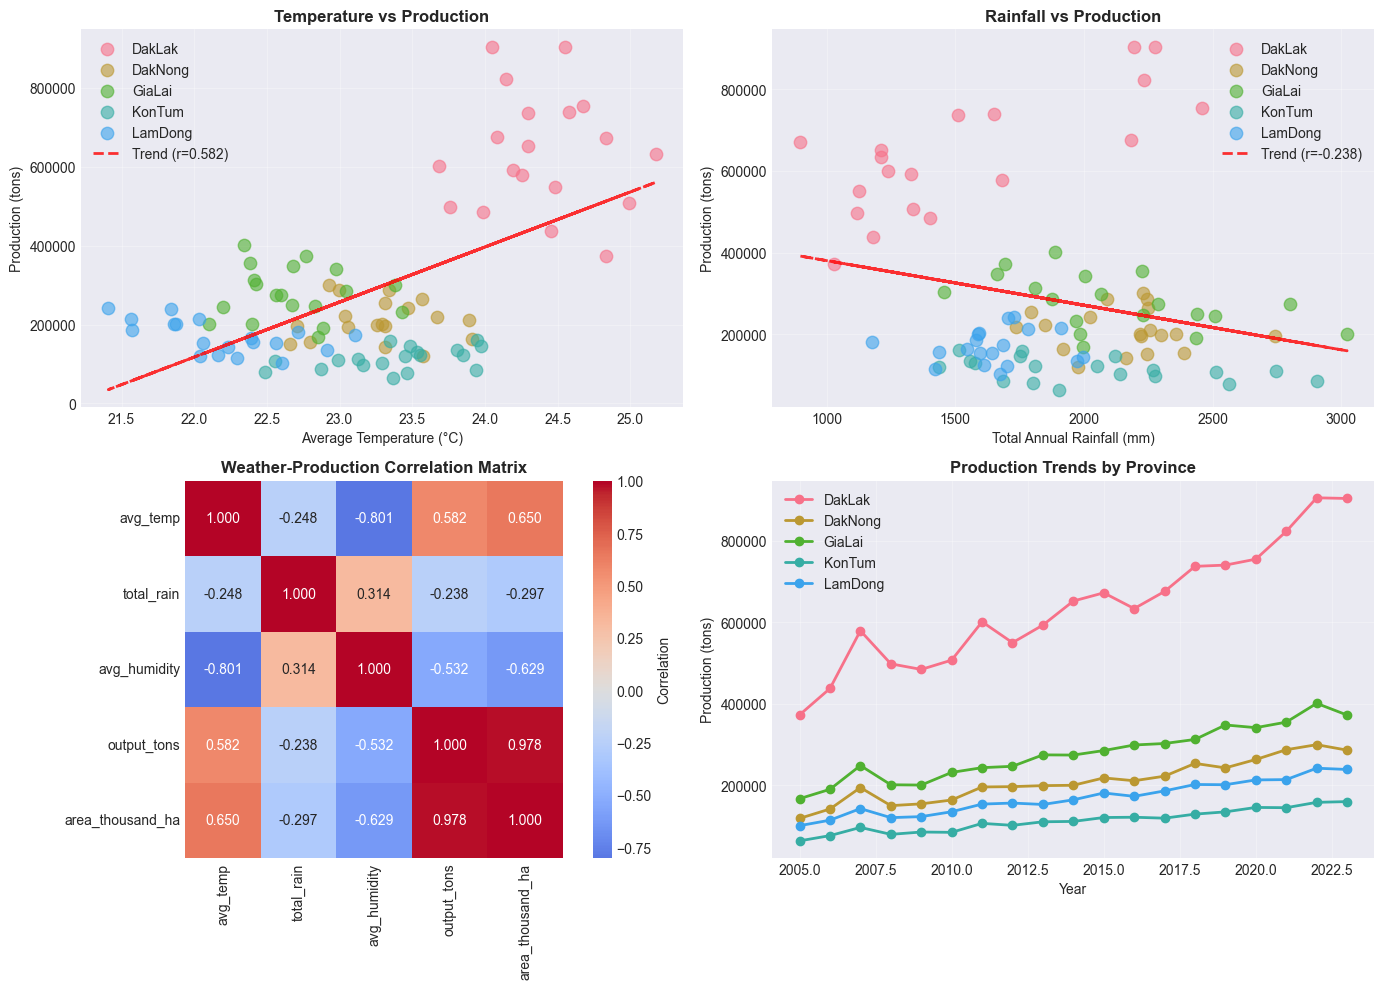


📊 Visualization: Weather-Production correlation analysis


In [23]:
# Visualize Weather-Production Correlation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Temperature vs Production
for province in df_weather_prod['province'].unique():
    df_prov = df_weather_prod[df_weather_prod['province'] == province]
    axes[0, 0].scatter(df_prov['avg_temp'], df_prov['output_tons'], 
                       label=province, alpha=0.6, s=80)

# Add trend line
z = np.polyfit(df_weather_prod['avg_temp'], df_weather_prod['output_tons'], 1)
p = np.poly1d(z)
axes[0, 0].plot(df_weather_prod['avg_temp'], p(df_weather_prod['avg_temp']), 
                "r--", alpha=0.8, linewidth=2, label=f'Trend (r={r_temp_prod:.3f})')

axes[0, 0].set_title('Temperature vs Production', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Average Temperature (°C)')
axes[0, 0].set_ylabel('Production (tons)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Rainfall vs Production
for province in df_weather_prod['province'].unique():
    df_prov = df_weather_prod[df_weather_prod['province'] == province]
    axes[0, 1].scatter(df_prov['total_rain'], df_prov['output_tons'], 
                       label=province, alpha=0.6, s=80)

z = np.polyfit(df_weather_prod['total_rain'], df_weather_prod['output_tons'], 1)
p = np.poly1d(z)
axes[0, 1].plot(df_weather_prod['total_rain'], p(df_weather_prod['total_rain']), 
                "r--", alpha=0.8, linewidth=2, label=f'Trend (r={r_rain_prod:.3f})')

axes[0, 1].set_title('Rainfall vs Production', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Total Annual Rainfall (mm)')
axes[0, 1].set_ylabel('Production (tons)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Correlation heatmap
sns.heatmap(corr_weather, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, ax=axes[1, 0],
            cbar_kws={'label': 'Correlation'})
axes[1, 0].set_title('Weather-Production Correlation Matrix', fontsize=12, fontweight='bold')

# Production by province over time
for province in df_weather_prod['province'].unique():
    df_prov = df_weather_prod[df_weather_prod['province'] == province]
    axes[1, 1].plot(df_prov['year'], df_prov['output_tons'], 
                    marker='o', label=province, linewidth=2)

axes[1, 1].set_title('Production Trends by Province', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Production (tons)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Visualization: Weather-Production correlation analysis")

---
## SUMMARY: Tổng hợp kết quả các kiểm định

In [24]:
# Create summary table
summary_data = {
    'Test': [
        'T-Test (DakLak vs DakNong)',
        'ANOVA (4 provinces)',
        'Pearson Correlation (Export ↔ World Price)',
        'Simple Regression (R²)',
        'Multiple Regression (R²)',
        'Weather-Production Correlation'
    ],
    'Statistic': [
        f't={t_statistic:.3f}',
        f'F={f_statistic:.3f}',
        f'r={r_coef:.3f}',
        f'R²={model_simple.rsquared:.3f}',
        f'R²={model_multi.rsquared:.3f}',
        f'r_temp={r_temp_prod:.3f}, r_rain={r_rain_prod:.3f}'
    ],
    'P-value': [
        f'{p_value:.4f}',
        f'{p_value_anova:.4f}',
        f'{p_value_corr:.4f}',
        f'{model_simple.f_pvalue:.4f}',
        f'{model_multi.f_pvalue:.4f}',
        f'{p_temp_prod:.4f}, {p_rain_prod:.4f}'
    ],
    'Result': [
        '✅ Significant' if p_value < 0.05 else '❌ Not significant',
        '✅ Significant' if p_value_anova < 0.05 else '❌ Not significant',
        '✅ Significant' if p_value_corr < 0.05 else '❌ Not significant',
        '✅ Good fit' if model_simple.rsquared > 0.5 else '⚠️ Moderate fit',
        '✅ Good fit' if model_multi.rsquared > 0.5 else '⚠️ Moderate fit',
        '✅ Temp significant' if p_temp_prod < 0.05 else '❌ Not significant'
    ]
}

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*100)
print("STATISTICAL ANALYSIS SUMMARY")
print("="*100)
print(df_summary.to_string(index=False))
print("="*100)

print("\n🎉 Analysis completed successfully!")
print("\n📝 Key Findings:")
print(f"   1. Price difference between provinces: {'Significant' if p_value < 0.05 else 'Not significant'}")
print(f"   2. Export-World Price correlation: r={r_coef:.3f} ({'Strong' if abs(r_coef) > 0.7 else 'Moderate'})")
print(f"   3. Regression model explains: {model_multi.rsquared*100:.1f}% of variance")
print(f"   4. Weather impact on production: {'Significant' if p_temp_prod < 0.05 else 'Limited'}")


STATISTICAL ANALYSIS SUMMARY
                                      Test                   Statistic        P-value             Result
                T-Test (DakLak vs DakNong)                    t=-1.034         0.3051  ❌ Not significant
                       ANOVA (4 provinces)                     F=4.965         0.0027      ✅ Significant
Pearson Correlation (Export ↔ World Price)                     r=0.770         0.0002      ✅ Significant
                    Simple Regression (R²)                    R²=0.592         0.0002         ✅ Good fit
                  Multiple Regression (R²)                    R²=0.869         0.0000         ✅ Good fit
            Weather-Production Correlation r_temp=0.582, r_rain=-0.238 0.0000, 0.0201 ✅ Temp significant

🎉 Analysis completed successfully!

📝 Key Findings:
   1. Price difference between provinces: Not significant
   2. Export-World Price correlation: r=0.770 (Strong)
   3. Regression model explains: 86.9% of variance
   4. Weather impa